In [10]:
import torch
import numpy as np
from dataclasses import dataclass, field
from typing import List, Tuple
import matplotlib.pyplot as plt

@dataclass
class Configs:
    
    #...general params:
    workdir : str = '../../results/gauss_test_1/'   
    device : str = 'cuda:3'
    multi_gpu : bool = False

    #...data params:
    target : str = 'TwoMoons'
    source : str = 'NGaussians'
    num_points : int = 70000
    dim_continuous : int = 2
    dim_discrete : int = 0
    dim_context : int = 0
    num_gaussians : int = 8
    vocab_size : int = 0

    #...model params:
    model : str = 'mlp'
    num_layers : int = 4
    dim_hidden : int = 128 
    dim_continuous_emb : int = 16
    continuous_embedding : str = 'kolmogorov-arnold'    
    dim_time_emb : int = 16
    time_embedding : str = 'kolmogorov-arnold'    
    dropout : float = 0.0
    activation : str = 'SELU'
    use_batch_norm : bool = False
    
    #...training params:
    batch_size : int = 256
    data_split_frac : List[float] = field(default_factory = lambda : [0.8, 0.2, 0.0])  # train / val / test 
    epochs: int = 500
    early_stopping : int = None
    min_epochs : int = None 
    print_epochs : int = None   
    num_workers : int = 0
    pin_memory: bool = False

    #...cfm params:
    dynamics : str = 'CFM'
    sigma: float = 1e-3

    #...optimization & scheduler params:
    optimizer: str = 'Adam'
    lr : float = 2e-4
    weight_decay : float = 0.0
    optimizer_betas : List[float] = field(default_factory = lambda : [0.9, 0.999])
    optimizer_eps : float = 1e-8
    optimizer_amsgrad : bool = False
    gradient_clip : float = None
    scheduler: str = None
    scheduler_t_max: int = None
    scheduler_eta_min: float = None
    scheduler_gamma: float = None
    scheduler_step_size: int = None

    #...generation pipeline params:
    sampler : str = 'EulerSolver'
    solver = 'euler'
    num_timesteps : int = 1000
    time_eps : float = 0

    def __post_init__(self):

        self.data = self.source + '_to_' + self.target

        if self.dim_discrete: 
            assert self.dim_discrete == 1
            self.dim_context = 0
            self.dim_context_emb = 0 
            self.num_colors = self.vocab_size
        else:
            self.dim_discrete_emb = 0
            self.num_colors = 1

        if self.dim_context:  
            assert self.dim_context == 1
            self.dim_discrete = 0
            self.dim_discretet_emb = 0 
            self.num_colors = self.vocab_size
        else:
            self.dim_context_emb = 0
            self.num_colors = 1

        if self.multi_gpu: self.device = 'cuda:0'



## CFM: 8-gaussians $\to$ 2-moons

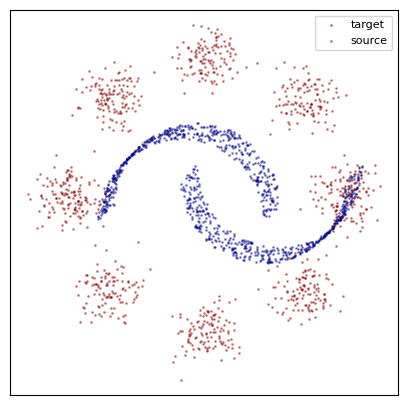

In [11]:
from cmb.data.toys import CouplingData

config = Configs()
toys = CouplingData(config=config)

_, ax = plt.subplots(1, 1, figsize=(5, 5)) 
toys.target.display(num_points=1000, s=1, ax=ax, cmap='tab10', alpha=0.4, color='darkblue', label='target')
toys.source.display(num_points=1000, s=1, ax=ax, cmap='tab10', alpha=0.4, color='darkred', label='source')
plt.legend(fontsize=8)
plt.show()

In [12]:
from cmb.dynamics.cfm import ConditionalFlowMatching, OTCFM
from cmb.models.trainers import CMBTrainer
from cmb.models.architectures.deep_nets import MLP

dynamics = OTCFM(config)
mlp = MLP(config)
generative_model = CMBTrainer(dynamics, mlp, toys)
generative_model.train()


number of training parameters: 37986
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 56000, validation size: 14000, testing sizes: 0


epochs:   0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
from cmb.models.pipelines import Pipeline

pipeline = Pipeline(trained_model=generative_model, config=config)
input = CouplingData(config=config)
pipeline.generate_samples(source_continuous=input.source.continuous)

def plot_trajectories(paths, title='flow-matching', N=2000, cmap='tab10', show_paths=False):
    """Plot trajectories of some selected samples."""
    plt.figure(figsize=(5,5))
    if show_paths:
        for i in range(N):
            plt.plot(paths[:, i, 0], paths[:, i, 1], alpha=0.3, lw=0.2, color='k')  # Plot lines for each trajectory
    plt.scatter(paths[0, :N, 0], paths[0, :N, 1], s=4, cmap=cmap, label='t=0')
    plt.scatter(paths[-1, :N, 0], paths[-1, :N, 1], s=4, cmap=cmap, label='t=1')
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.axis('equal')
    plt.show()

CFM:

/tmp/ipykernel_720902/2124687817.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(paths[0, :N, 0], paths[0, :N, 1], s=4, cmap=cmap, label='t=0')
/tmp/ipykernel_720902/2124687817.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(paths[-1, :N, 0], paths[-1, :N, 1], s=4, cmap=cmap, label='t=1')


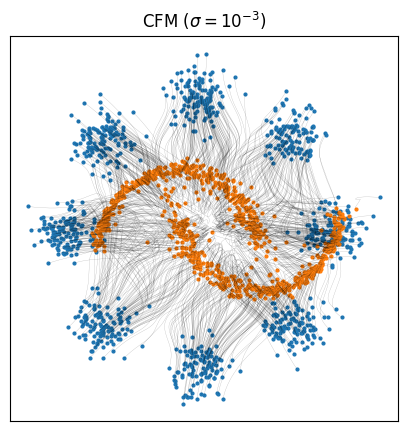

In [6]:
plot_trajectories(pipeline.paths, title='CFM ($\sigma=10^{-3}$)', N=1000,  show_paths=True)

OT-CFM:

/tmp/ipykernel_728554/2124687817.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(paths[0, :N, 0], paths[0, :N, 1], s=4, cmap=cmap, label='t=0')
/tmp/ipykernel_728554/2124687817.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(paths[-1, :N, 0], paths[-1, :N, 1], s=4, cmap=cmap, label='t=1')


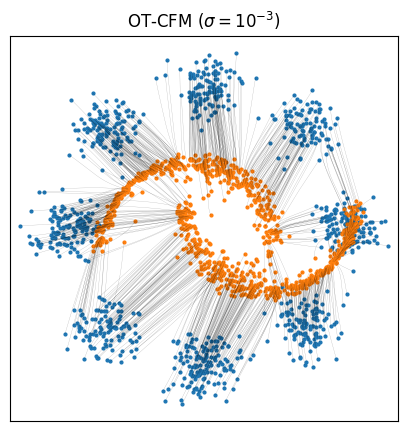

In [7]:
plot_trajectories(pipeline.paths, title='OT-CFM ($\sigma=10^{-3}$)', N=1000,  show_paths=True)

In [ ]:
plot_trajectories(pipeline.paths, title='KAN OT-CFM ($\sigma=10^{-3}$)', N=1000,  show_paths=True)